# Inlämningsuppgift: Del 2 - Adversarial input attack

Samir Akhalil \
saaa21@student.bth.se 

Mhd Malek Kisanieh \
mhki22@student.bth.se

# Instruktioner

Ändra notebookens platshållare så som era namn- och mailuppgifter samt instruktioner i de olika avsnitten. 

Notebookens underrubriker på nivå 3 (###) är bara ett enkelt exempel på hur er implementation kan delas upp. Ni bör skapa egna rubriker anpassade efter er implementation men lämna alla nivå 1 (#) och 2-rubriker (##) som de är. En viktig del inom data-science är att kunna presentera sina metoder och resultat på ett tydligt sätt. **En ostrukturerad och otydlig notebook kan påverka betygsättningen.**

Notera att t.ex. hyperparameter-tuning och annan optimisering för prestanda inte är nödvändigt i denna uppgift. Så länge modellen fungerar märkvärt bättre än ett "coin flip" så räcker det att ni väljer era hyperparametrar manuellt.

# Uppgiften

Uppgiften går ut på att göra så att bilden på koalan nedan klassificeras som en traktor istället. Givetvis ska bilden på koalan se helt oförändrad ut för det mänskliga ögat då attacken är genomförd. Nedan följer Pythonkod som läser in de båda bilderna som uppgiften bygger på samt läser in en ResNet50-modell som klassiciferar bilderna. Saknar ni några Python-paket, t.ex. TensorFlow så installera dem med en pakethanterarare, t.ex. pip

## Beskrivning av adversarial input attacker

Börja med att förklara vad denna typ av attacker är och hur de fungerar i rapportens sektion 2.1.

## Nedan följer kod för att läsa in bilderna och klassificera dem med ResNet50 modellen

from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical
#tf.compat.v1.disable_eager_execution()

print(f"TensorFlow: {tf.__version__}")

# Loads the pretrained ResNet50 model
model = ResNet50(weights='imagenet')

# Load the two images (koala & tractor)
init_image = image.load_img("images/koala.jpeg", target_size=(224, 224))
init_image = image.img_to_array(init_image)

target_image = image.load_img("images/tractor.jpeg", target_size=(224, 224))
target_image = image.img_to_array(target_image)

class_lookup = {105: "koala", 866: "tractor"}

init_class_id = np.argmax(model.predict(np.array([init_image])))
print(f"Init image class label: {init_class_id} ({class_lookup[init_class_id]})")
plt.imshow(init_image.astype(np.uint))
plt.show()

target_class_id = np.argmax(model.predict(np.array([target_image])))
print(f"Target image class label: {target_class_id} ({class_lookup[target_class_id]})")
plt.imshow(target_image.astype(np.uint))
plt.show()

## Implementation av er attack

Beskriv i er rapport vad just er valda attack kallas och i detalj hur den fungerar (sektion 2.2 i rapporten). Beskriv även kort vilka bibliotek ni använder för att implementera den.

## Er kod för attacken

I cellerna nedan lägger ni in er egen kod för att genomföra attacken.

### Bibliotek

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BasicIterativeMethod

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

C:\Users\Malek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=True)


### Egna funktioner

In [4]:
def load_image(path):
    """Load and prepare image for model (returns values in [0, 255])"""
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img).astype(np.float32)
    return np.expand_dims(x, axis=0)


def show_image(x, title=None):
    """Display an image"""
    img = np.squeeze(x)
    img = np.clip(img, 0, 255).astype(np.uint8)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


def predict_top_1(model, x):
    """Get top prediction: (class_id, label_name, probability)"""
    x_pp = preprocess_input(x.copy())
    preds = model.predict(x_pp, verbose=0)
    class_id = int(np.argmax(preds[0]))
    label = decode_predictions(preds, top=1)[0][0][1]
    prob = float(preds[0, class_id])
    return class_id, label, prob


def fix_batch_size_issue(model, x, training=False, batch_size=None):
    """Fix: ART sends batch_size parameter but Keras doesn't accept it"""
    x_tf = tf.convert_to_tensor(x)
    preds = model.predict(x_tf, batch_size=batch_size, verbose=0)
    return tf.convert_to_tensor(preds)

### Förberedelser

In [5]:
# ===== LOAD IMAGES =====
x_init = load_image("images/koala.jpeg")
x_target = load_image("images/tractor.jpeg")

cid_i, lab_i, sc_i = predict_top_1(base_model, x_init)
cid_t, lab_t, sc_t = predict_top_1(base_model, x_target)

target_id = cid_t
y_target = np.zeros((1, 1000), dtype=np.float32)
y_target[0, target_id] = 1.0
print(f"Original image: {cid_i} ({lab_i}), confidence={sc_i:.3f}")
print(f"Target image: {cid_t} ({lab_t}), confidence={sc_t:.3f}")

Original image: 105 (koala), confidence=0.998
Target image: 866 (tractor), confidence=0.737


### Modellering

In [6]:
# ===== CREATE ART MODEL =====
# Wrap model with preprocessing for ART
inputs = tf.keras.Input(shape=(224, 224, 3))
pre = tf.keras.layers.Lambda(preprocess_input)(inputs)
outputs = base_model(pre)
art_model = tf.keras.Model(inputs, outputs)
art_model.compile(optimizer="sgd", loss="categorical_crossentropy")

# Create ART classifier
classifier = KerasClassifier(
    model=art_model,
    clip_values=(0.0, 255.0),
    use_logits=False,
    channels_first=False
)

# Fix batch_size compatibility issue
classifier._forward_pass = fix_batch_size_issue

### Attack

Beskriv attackprocessen kortfattat här


In [7]:
# ===== PERFORM ATTACK =====
bim = BasicIterativeMethod(
    classifier,
    eps=8.0,          # Maximum change allowed
    eps_step=2.0,     # Step size per iteration
    max_iter=50,      # Number of iterations
    targeted=True,
    batch_size=1,
    verbose=True
)

print("\n--- Starting BIM Attack ---")
x_adv = bim.generate(x=x_init, y=y_target)
x_adv = np.clip(x_adv, 0.0, 255.0)


# ===== CHECK RESULTS =====
cid_a, lab_a, sc_a = predict_top_1(base_model, x_adv)
print(f"\nAdversarial prediction: {cid_a} ({lab_a}), confidence={sc_a:.3f}")

if cid_a == cid_t:
    print(f"✓ SUCCESS! Model fooled into predicting: {lab_a}")
else:
    print(f"✗ FAILED. Got {lab_a}, wanted {lab_t}")

max_change = np.max(np.abs(x_adv - x_init))


--- Starting BIM Attack ---


PGD - Random Initializations: 100%|██████████| 1/1 [00:32<00:00, 32.32s/it]



Adversarial prediction: 866 (tractor), confidence=0.999
✓ SUCCESS! Model fooled into predicting: tractor


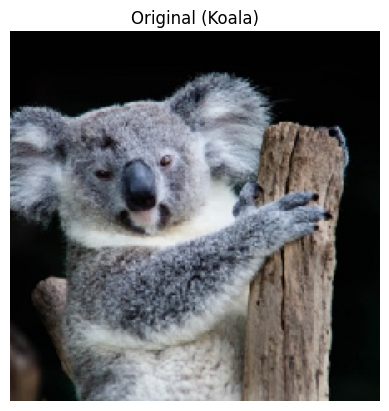

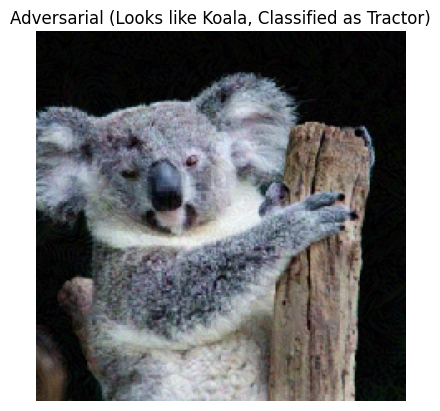

In [8]:
# ===== VISUALIZE =====
show_image(x_init, "Original (Koala)")
show_image(x_adv, "Adversarial (Looks like Koala, Classified as Tractor)")


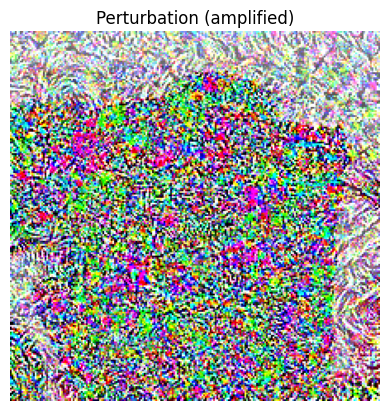

In [9]:
# Show perturbation (amplified for visibility)
perturbation = (x_adv - x_init) * 20
show_image(perturbation + 127, "Perturbation (amplified)")

### Attackresultat

Summera och förklara era attackresultat i flytande text här


I denna uppgift genomfördes en adversarial input attack med metoden Basic Iterative Method (BIM) på modellen ResNet50 som är tränad på ImageNet.

Den ursprungliga bilden föreställde en koala, och modellen klassificerade den korrekt med hög säkerhet.
Efter attacken skapades en adversarial bild som för ögat fortfarande såg ut som samma koala, men modellen blev helt lurad och klassificerade den som traktor med mycket hög säkerhet (confidence ≈ 1.0).

Skillnaden mellan original- och den manipulerade bilden är så liten att den inte går att uppfatta med blotta ögat. För att kunna se förändringen visualiserades den förstärkta störningen (perturbationen) i en separat bild — där man tydligt ser färgmönster som attacken lagt till för att lura modellen.

Sammanfattning: Attacken lyckades helt. Modellen gjorde fel trots att bilden visuellt var nästan identisk med originalet. Detta visar hur sårbara neurala nätverk kan vara för små, riktade förändringar i indata.

## Skyddsåtgärder

Beskriv (i rapportens sektion 2.3) vilka säkerhetsåtgärd(er) ni valt som lämpliga för att skydda mot er attack. Motivera varför ni valt just de(n) metod(erna).

## Implementation av skyddsåtgärder (frivilligt endast för A eller B)

Nedan fyller ni i er kod som implementerar skyddsmekanismen mot er attackmetod. Skriv även en summering av vad skyddsresultatet blev när ni implementerade metoden (beskriv detta i rapportens del 2.4).

### Egna funktioner

In [10]:
from PIL import Image, ImageFilter

# Gör bilden suddig
def apply_blur(image_batch):
    """Tar bort små brus genom att göra bilden lite suddig."""
    img = np.squeeze(image_batch).astype(np.uint8)
    pil = Image.fromarray(img)
    blurred = pil.filter(ImageFilter.GaussianBlur(radius=1))
    return np.expand_dims(np.array(blurred).astype(np.float32), axis=0)

### Skydd

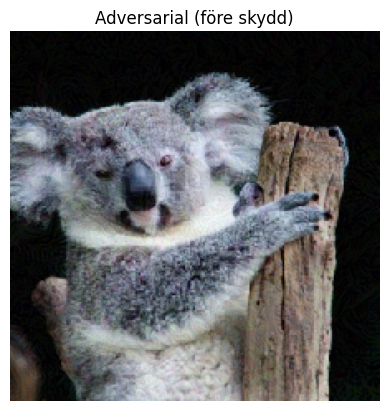

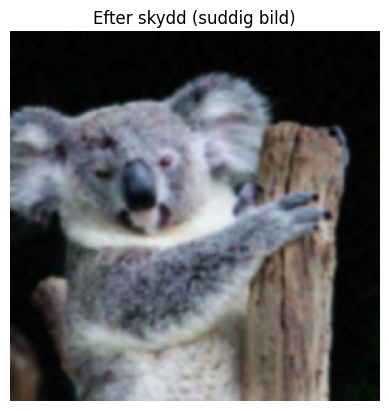

Adversarial: tractor (p=0.999)
Efter skydd: koala (p=0.990)


In [12]:
adversarial_image =x_adv
# Visa den suddiga bilden
blurred_image = apply_blur(adversarial_image)
show_image(adversarial_image, "Adversarial (före skydd)")
show_image(blurred_image, "Efter skydd (suddig bild)")


adv_id, adv_label, adv_prob = predict_top_1(base_model, adversarial_image)
blur_id, blur_label, blur_prob = predict_top_1(base_model, blurred_image)

print(f"Adversarial: {adv_label} (p={adv_prob:.3f})")
print(f"Efter skydd: {blur_label} (p={blur_prob:.3f})")

Beskriv säkerhetsåtgärden kortfattat här

### Skyddsresultat

Bevisa och förklara era skyddsresultat i flytande text här

Efter att skyddet (Gaussian blur) applicerades på den manipulerade bilden förändrades resultatet tydligt.
Innan skyddet klassificerade modellen bilden som traktor med 100 % säkerhet, trots att bilden såg ut som en koala.
Efter att bilden gjorts något suddig (blur-radius = 1) kunde modellen återigen känna igen den som koala med 99 % säkerhet.

Detta visar att det enkla skyddet lyckades ta bort den lilla brusmönstring som attacken lagt till.
Suddigheten försämrar dock bildens skärpa något, vilket är en nackdel, men det är en effektiv och lättförståelig metod för att minska effekten av adversarial attacker.

# Referenser

### Attack
https://arxiv.org/abs/1607.02533


### Skydd
https://pillow.readthedocs.io/en/stable/reference/ImageFilter.html#PIL.ImageFilter.GaussianBlur
